<a href="https://colab.research.google.com/github/rockey1006/Variational-Autoencoders/blob/master/10LDF%2BVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.resnet import ResNet101
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.transform import resize
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
base_model = ResNet101(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


Using TensorFlow backend.














179650560/179648224 [==============================] - 6s 0us/step


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#from google.colab import files
#uploaded = files.upload()

In [0]:
import tarfile
tar = tarfile.open('/content/drive/My Drive/lfw.tgz')
names = tar.getnames()
for name in names:
  tar.extract(name,path='/content/lfw')
tar.close()

In [4]:
paths_path = "/content/lfw/lfw/*/*"
paths_list = glob.glob(paths_path)
paths_list[:1]
labels = [p.split("/")[-1].split("00")[0].replace("_", " ").rstrip() for p in paths_list]
labels[:5]
len(labels)#13233 images
#5749 people
#1680 people with two or more images

13233

In [5]:
face_labels = pd.Series(labels)
top_faces = face_labels.value_counts()[:10]
top_face_names = top_faces.index
top_face_names


Index(['Gerhard Schroeder', 'Donald Rumsfeld', 'George W Bush', 'Tony Blair',
       'Colin Powell', 'Ariel Sharon', 'Hugo Chavez', 'Junichiro Koizumi',
       'Jean Chretien', 'John Ashcroft'],
      dtype='object')

In [6]:

face_lookup = pd.Series(top_face_names)
face_lookup = face_lookup.reset_index()
face_lookup.columns = ['num_label', 'name']
face_lookup.head()
fac_labels = face_labels.reset_index()
fac_labels.columns = ['idx', 'name']
fac_labels.head()
mgd = pd.merge(fac_labels, face_lookup, how="inner", left_on='name', right_on="name")
mgd.head()
mgd.shape

(811, 3)

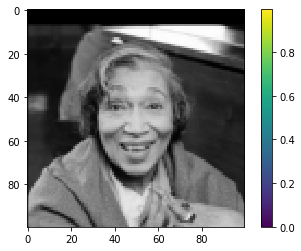

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
df = mgd.set_index("idx")
df = mgd['name']
y = mgd['num_label'] 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, 
                                                    random_state=42)
img_train = [imread(img) for i, img in enumerate(paths_list) if i in X_train.index]
img_test = [imread(img) for i, img in enumerate(paths_list) if i in X_test.index]

def resize_image(img):
    img = resize(img, (100, 100), anti_aliasing=True)
    return img

def rescale_image(img):
    return img /255

#First resize...
img_train = [resize_image(i) for i in img_train]
img_test = [resize_image(i) for i in img_test]

    

#...then output a sample to check it has worked...
io = resize_image(img_train[0])
plt.figure()
plt.imshow(io)
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
print(img_train[0].shape)

(100, 100, 3)


In [0]:
batch_size = 10
original_dim = 30000
latent_dim = 2
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)#中间结果h，隐藏层256个结点，激活函数relu
z_mean = Dense(latent_dim)(h)#隐变量输出层1有2 个结点
z_log_var = Dense(latent_dim)(h)#隐变量输出层2有2个结点

In [42]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])#输入是z_mean和z_log_var，输出是z
decoder_h = Dense(intermediate_dim, activation='relu')#隐藏层
decoder_mean = Dense(original_dim, activation='sigmoid')#输出层
h_decoded = decoder_h(z)#中间值
x_decoded_mean = decoder_mean(h_decoded)#输出值
vae = Model(x, x_decoded_mean)
#model = Model(inputs=[a1, a2], outputs=[b1, b3, b3])

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #KL+交叉熵
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss) #复杂损失函数所以不在compile声明，而使用add_loss
vae.compile(optimizer='rmsprop') #用于配置训练模型。

#compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None, 
#weighted_metrics=None, target_tensors=None)

vae.summary() #model.summary()：打印出模型概况，它实际调用的是keras.utils.print_summary


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 30000)        0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 256)          7680256     input_7[0][0]                    
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 2)            514         dense_22[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 2)            514         dense_22[0][0]                   
____________________________________________________________________________________________

In [43]:
x_train = np.array(img_train) 
print(x_train.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
print(x_train.shape)

(648, 100, 100, 3)
(648, 30000)


In [44]:
x_test = np.array(img_test) 
print(x_test.shape)
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))#改变shape
print(x_test.shape)

(163, 100, 100, 3)
(163, 30000)


In [0]:
x_train = x_train.astype('float32') / 255.#数据预处理归一化
x_test = x_test.astype('float32') / 255.#数据预处理归一化



In [51]:
vae.fit(x_train,#算输出和输入分布的差异所以没有y
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))

Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 13s - loss: 354.2063 - val_loss: 345.4779
Epoch 2/20
 - 12s - loss: 352.3973 - val_loss: 344.3207
Epoch 3/20
 - 12s - loss: 350.8195 - val_loss: 343.3084
Epoch 4/20
 - 12s - loss: 350.1871 - val_loss: 342.1876
Epoch 5/20
 - 12s - loss: 348.8609 - val_loss: 340.8027
Epoch 6/20
 - 12s - loss: 347.8751 - val_loss: 342.0319
Epoch 7/20
 - 12s - loss: 346.8882 - val_loss: 342.5132
Epoch 8/20
 - 12s - loss: 346.2241 - val_loss: 340.2234
Epoch 9/20
 - 12s - loss: 345.8586 - val_loss: 339.0260
Epoch 10/20
 - 12s - loss: 345.1863 - val_loss: 338.9375
Epoch 11/20
 - 12s - loss: 344.8248 - val_loss: 338.3350
Epoch 12/20
 - 12s - loss: 344.5440 - val_loss: 340.5742
Epoch 13/20
 - 12s - loss: 344.0965 - val_loss: 337.5193
Epoch 14/20
 - 12s - loss: 343.5969 - val_loss: 337.8186
Epoch 15/20
 - 12s - loss: 342.9225 - val_loss: 337.3438
Epoch 16/20
 - 12s - loss: 341.7457 - val_loss: 335.8704
Epoch 17/20
 - 12s - loss: 341.3629 - val_loss: 335

In [0]:
encoder = Model(x, z_mean)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [48]:
plt.figure(figsize=(18, 16), dpi=200)#Create a new figure.

<Figure size 3600x3200 with 0 Axes>

<Figure size 3600x3200 with 0 Axes>

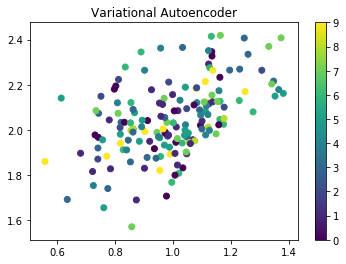

In [49]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],c=y_test)
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()
